In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import os
import h5py
from sklearn.linear_model import TweedieRegressor
from sklearn.preprocessing import StandardScaler

In [3]:
import scipy.io as spio

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

# Trying to parse the results pupil mat file

In [5]:
# location of pupil test struct
data_dir=r"C:\Users\Mitchell\Documents\PITT\Fall_2021\Williamson_lab\2P\Data\NS_results_120&154_9.3.21.mat"
day = 2
parameter_file = 1
f = h5py.File(data_dir, 'r')['results']
# this package generates references that we then feed back into the original file
# I'm sure this isn't great, but it works for now
ref_1 = f['FOV'][0,0] # this can be changed for different animals
ref_2 = f[ref_1]['Day'][day][0] # first number can be changed for different days
spikes_ref = f[ref_2]['Experiment']['spike_traces'][parameter_file,0]
sequence_ref = f[ref_2]['Experiment']['inner_sequence'][parameter_file, 0]
index_ref = f[ref_2]['Experiment']['inner_index'][parameter_file, 0]
responsive_ref = f[ref_2]['Experiment']['resp'][parameter_file, 0]
# now that we have all our references, we can get the actual arrays
spikes = np.array(f[spikes_ref]).swapaxes(0,2)
inner_sequence = np.array(f[sequence_ref]).reshape(-1,)
inner_index = np.array(f[index_ref][:]).reshape(-1,).astype(int)
pupil = np.array(f[ref_2]['pupilStruct']['FreqOneD']['pupilMatrix']).T
resp = np.array(f[responsive_ref][:]).reshape(-1)

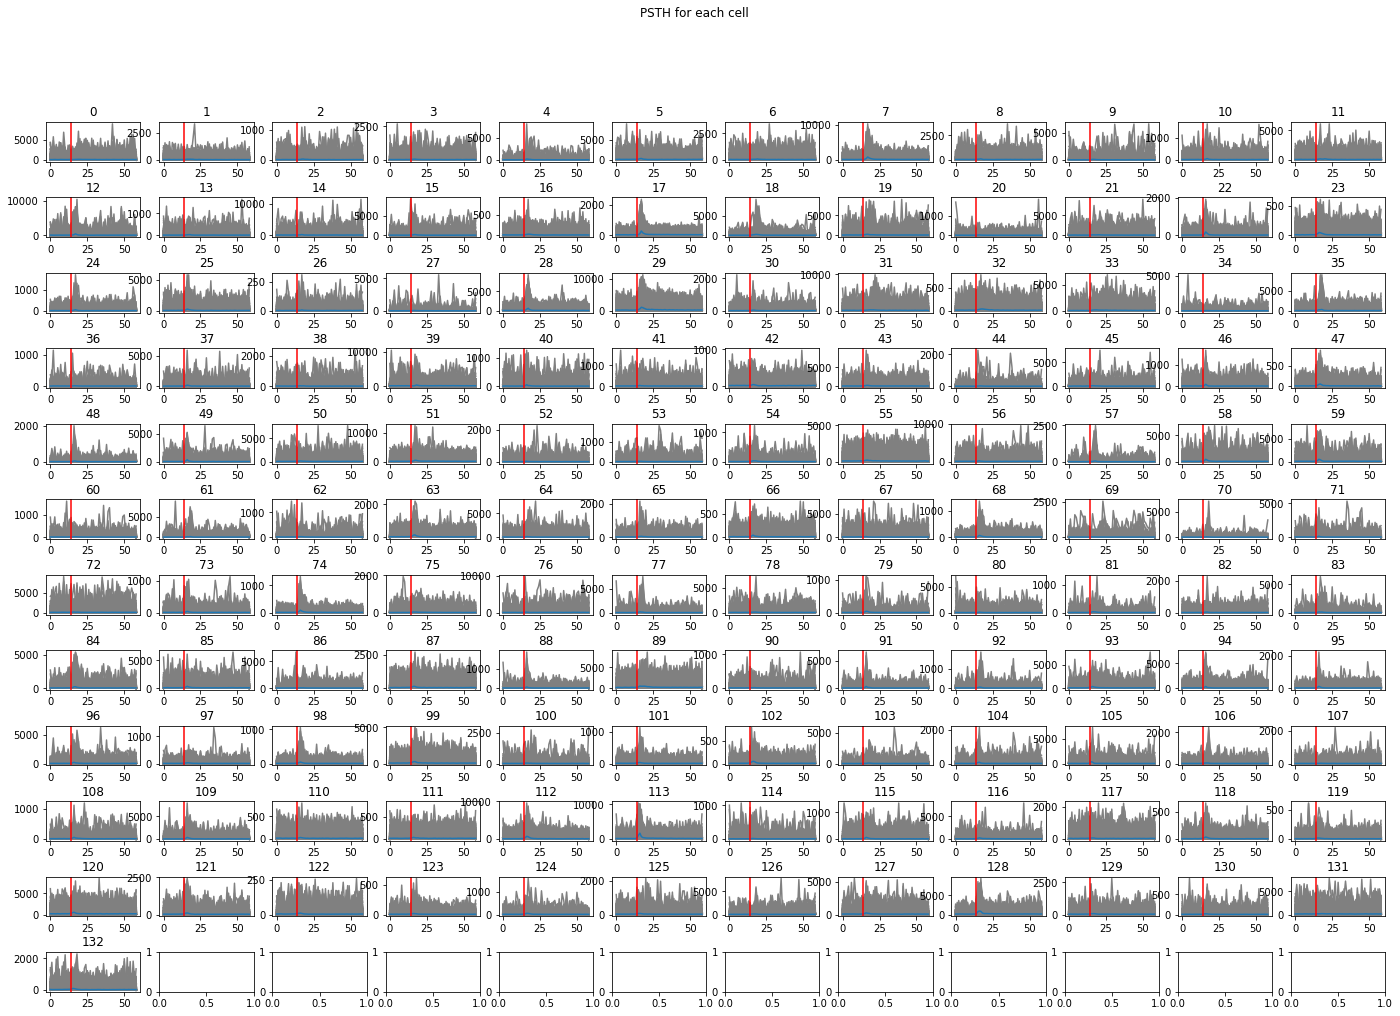

In [10]:
# https://rayheberer.medium.com/generating-matplotlib-subplots-programmatically-cc234629b648
num_cols = np.around(np.sqrt(len(responsive_cells))).astype(int)
fig, axes = plt.subplots(nrows=num_cols, ncols=num_cols, figsize=(24,16))
fig.subplots_adjust(hspace=0.9)
fig.suptitle('PSTH for each cell')
cell_counter = 0 
for ax, cell in zip(axes.flatten(), responsive_cells):
    ax.plot(np.arange(0,59), cell, c='grey')
    ax.plot(np.arange(0,59), np.mean(cell, axis=1), label = 'Mean')
    ax.axvline(x = 14,color= 'r', label='Stimulus onset')
    ax.set(title=str(cell_counter))
    cell_counter+=1

In [6]:
scaled_sequence = [np.log(i)/np.log(np.max(inner_sequence)) for i in inner_sequence]
# scaled_sequence2 = [(np.log(i) - np.log(min(inner_sequence)))/(np.log(max(inner_sequence))-np.log(min(inner_sequence))) for i in inner_sequence]

# get stimulus for each trial, stimulus is presented at frame 15
Stim = np.zeros_like(pupil)
Stim[14,:] = [scaled_sequence[i-1] for i in inner_index]

Stim = Stim.flatten(order='F')

# flatten pupil signal
pupil_resp = pupil.flatten(order='F')/100

# loop through responsive cells 
response_index = np.where(resp==1)[0]
responsive_cells = spikes[response_index,:59,:]

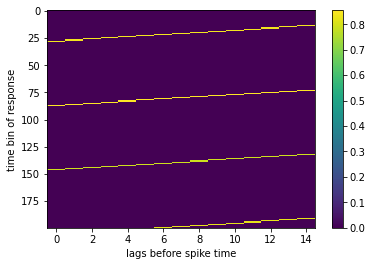

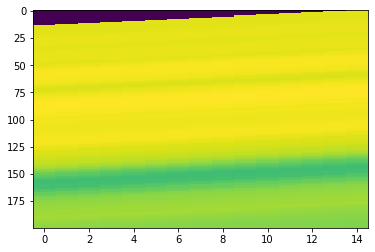

In [36]:
### ==== 3. Build the design matrix: slow version ======
# This is a necessary step before we can fit the model: assemble a matrix
# that contains the relevant regressors for each time bin of the response,
# known as a design matrix.  Each row of this matrix contains the relevant
# stimulus chunk for predicting the spike count at a given time bin
nT = len(Stim)
### Set the number of time bins of stimulus to use for predicting spikes
ntfilt = 15     # Try varying this, to see how performance changes!

# Build the design matrix: Slow version
paddedStim = np.hstack((np.zeros((ntfilt-1)), Stim))  # pad early bins of stimulus with zero
padded_pupil = np.hstack((np.zeros((ntfilt-1)), pupil_resp))
Xdsgnstim = np.zeros((nT,ntfilt))
Xdsgnpupil = np.zeros((nT,ntfilt))
for j in np.arange(nT):
    Xdsgnstim[j] = paddedStim[j:j+ntfilt]                 # grab last 'nkt' bins of stmiulus and insert into this row
    Xdsgnpupil[j] = padded_pupil[j:j+ntfilt]
    
# Let's visualize a small part of the design matrix just to see it
plt.imshow(Xdsgnstim[:200], aspect='auto', interpolation='nearest')
plt.xlabel('lags before spike time')
plt.ylabel('time bin of response')
plt.colorbar()
plt.show()

plt.imshow(Xdsgnpupil[:200], aspect='auto', interpolation='nearest')
# Notice it has a structure where every row is a shifted copy of the row
# above, which comes from the fact that for each time bin of response,
# we're grabbing the preceding 'nkt' bins of stimulus as predictor
Xdsgn = np.concatenate((Xdsgnstim,Xdsgnpupil,), axis = 1)

In [13]:
plot = False
color_dict = {}
color_list = ['black', 'grey', 'maroon', 'red', 'tomato', 'orange', 'lightyellow', 'greenyellow', 'seagreen', 'teal', 'skyblue',
             'steelblue', 'blue', 'mediumpurple', 'plum', 'magenta', ]
for index, freq in enumerate(np.unique(Stim)): 
    color_dict[freq] = color_list[index]

coef_list = []
performance_list = []
for cell in responsive_cells[true_resp,:]:
    
    responses = np.reshape(cell.flatten(order = 'F'), (-1,1))
    
    # Construct design matrix 
    Xdsgn_final = np.hstack((Xdsgn,responses))
    Xdsgn_final= Xdsgn_final[~np.isnan(Xdsgn_final).any(axis=1)]
    
    X = Xdsgn_final[:,:-1]
    y = Xdsgn_final[:,-1]
    
    # fit tweedie regressor with poisson (power=1)
    reg = TweedieRegressor(power=1, alpha=0.05, fit_intercept=True, link='log', max_iter=1000)
    reg.fit(X=X, y=y)
    coef_list.append(reg.coef_)
    predictions = reg.predict(X)
    performance_list.append(reg.score(X,y))
    if plot == True:
        plotlen=1000
        fig, ax = plt.subplots(figsize = (40,8))
        ax.plot(y[:plotlen],'grey', label = 'Actual')
        ax.plot(np.arange(0,plotlen), predictions[:plotlen], 'cyan', label='Predicted')

        # Mark stimulus onsets
        for stim_index in np.where(Stim != 0)[0]:
            if stim_index < plotlen:
                ax.axvline(x = stim_index,color= color_dict[Stim[stim_index]], label=str(Stim[stim_index]))

    print('D^2 = ', reg.score(X,y))
    
#     axes[0].plot(reg.coef_[:ntfilt])
#     axes[1].plot(reg.coef_[ntfilt:])

D^2 =  0.09363817768488103


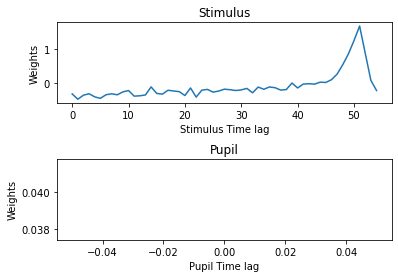

In [14]:
coef_array = np.array(coef_list)
stim_coef = np.array(coef_array[:,:ntfilt]).T
pupil_coef = np.array(coef_array[:,ntfilt:]).T
coef_fig, axes = plt.subplots(2,1)
coef_fig.subplots_adjust(hspace=0.7)
axes[0].set_title('Stimulus')
axes[0].set_xlabel('Stimulus Time lag')
axes[0].set_ylabel('Weights');
axes[1].set_title('Pupil')
axes[1].set_xlabel('Pupil Time lag')
axes[1].set_ylabel('Weights');
axes[0].plot(stim_coef);
axes[1].plot(np.mean(pupil_coef));

# Cross validation time! 

In [57]:
from sklearn.model_selection import KFold, GridSearchCV
from tqdm import tqdm
from sklearn.model_selection import cross_val_score

100%|██████████| 133/133 [12:37<00:00,  5.70s/it]


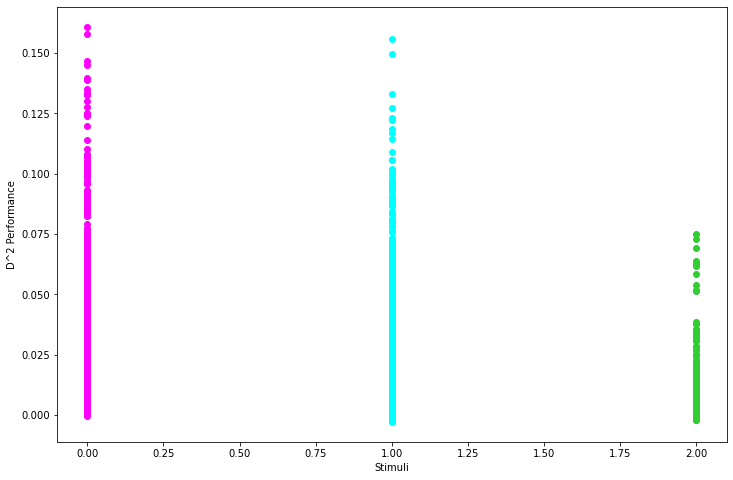

In [68]:
# for plotting
performance_fig, ax = plt.subplots(figsize = (12,8))
ax.set_xlabel('Stimuli')
ax.set_ylabel('D^2 Performance')
#     ax.set_ylim(0,1)
score_dict = {'Cell_num':[],
              'Combined': [], 
              'Sound_only': [], 
              'Pupil_only': []
             }
for index, cell in enumerate(tqdm(responsive_cells)):
    
    responses = np.reshape(cell.flatten(order = 'F'), (-1,1))
    
    # Construct design matrices 
    Xdsgn_final = np.hstack((Xdsgn,responses))
    Xdsgn_final= Xdsgn_final[~np.isnan(Xdsgn_final).any(axis=1)]
    X = Xdsgn_final[:,:-1]
    y = Xdsgn_final[:,-1]
    X_stim = Xdsgn_final[:,:ntfilt]
    X_pupil = Xdsgn_final[:,ntfilt:-1]
    matrix_dict = {'Combined': X, 
                   'Sound_only': X_stim, 
                   'Pupil_only': X_pupil
                  } 
    
    stim_colors = ['magenta','cyan','limegreen']
    stim_counter = 0
    for key, data in matrix_dict.items():
        n_splits = 5
        # set up k fold cross validation
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
#         alphas = np.logspace(-4, -0.5, 20)

        # fit tweedie regressor with poisson (power=1)
        reg = TweedieRegressor(power=1, 
                               fit_intercept=True, 
                               alpha=0.0162, 
                               link='log', 
                               max_iter=10000)
#         gscv = GridSearchCV(reg, cv=kf, n_jobs=1)
#         gscv.fit(i,y)
#         # get cv data
#         cv_df = pd.DataFrame(gscv.cv_results_)
        scores = cross_val_score(reg, data, y, cv=kf)
        score_dict[key].append(scores[:])
        score_dict['Cell_num'].append([index]*n_splits)
        # plot performance
        ax.scatter(x = np.repeat(stim_counter, len(scores)), 
                   y = scores, 
                   c = stim_colors[stim_counter])
        
        
#         ax.semilogx(alphas, scores, c = stim_colors[stim_counter])
        # plot error lines showing +/- std. errors of the scores
#         scores_std = cv_df.std_test_score
#         std_error = scores_std / np.sqrt(5)
#         ax.semilogx(alphas, scores + std_error, stim_colors[stim_counter]+'--')
#         ax.semilogx(alphas, scores - std_error, stim_colors[stim_counter]+'--')
#         ax.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
        stim_counter += 1

In [75]:
score_dict_clean = {key:np.array(i).flatten() for key, i in score_dict.items()}

In [85]:
score_df = pd.DataFrame(score_dict_clean)

In [86]:
score_df

Combined  Sound_only  Pupil_only
0    0.001657    0.000558    0.000155
1    0.001297    0.001443   -0.000258
2    0.000781    0.000445    0.000170
3    0.000514    0.001633   -0.001075
4    0.001015    0.000568    0.000400
..        ...         ...         ...
660  0.029357    0.026238    0.004108
661  0.018683    0.015602    0.003642
662  0.031500    0.030928    0.001166
663  0.037313    0.034282    0.003740
664  0.031080    0.027760    0.004161

[665 rows x 3 columns]

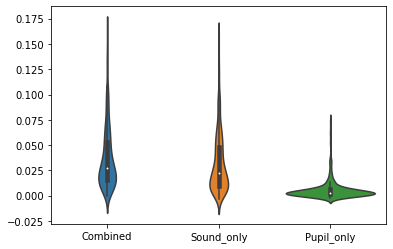

In [90]:
sns.violinplot(data=score_df);